In [2]:
import datetime
print(f"Notebook last run(end-to-end): {datetime.datetime.now()}")

Notebook last run(end-to-end): 2024-04-18 17:59:02.846555


In [3]:
!git clone https://github.com/Franck-Dernoncourt/pubmed-rct.git
!dir pubmed-rct

Cloning into 'pubmed-rct'...
remote: Enumerating objects: 39, done.
remote: Counting objects: 100% (14/14), done.
remote: Compressing objects: 100% (9/9), done.
remote: Total 39 (delta 8), reused 5 (delta 5), pack-reused 25
Receiving objects: 100% (39/39), 177.08 MiB | 25.19 MiB/s, done.
Resolving deltas: 100% (15/15), done.
Updating files: 100% (13/13), done.
PubMed_200k_RCT				       PubMed_20k_RCT_numbers_replaced_with_at_sign
PubMed_200k_RCT_numbers_replaced_with_at_sign  README.md
PubMed_20k_RCT


In [4]:
# Check what files are in the PubMed_20K dataset
!dir pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign

dev.txt  test.txt  train.txt


In [5]:
# Start by using the 20k dataset
data_dir = "pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/"

In [6]:
# Check all the filenames in the target directory
import os
filenames = [data_dir + filename for filename in os.listdir(data_dir)]
filenames

['pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/test.txt',
 'pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/dev.txt',
 'pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/train.txt']

## Preprocess data

In [7]:
def get_lines(filename):
    """
    Reads filename (a text file) and returns the lines of text as a list
    Args:
        filename: a string containing the target per line from the target filename.
    Returns:
        A list of strings with one string per line from the target filename.
    """
    with open(filename, "r") as f:
        return f.readlines()

In [8]:
train_lines = get_lines(data_dir+"train.txt")
train_lines[:5]

['###24293578\n',
 'OBJECTIVE\tTo investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .\n',
 'METHODS\tA total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .\n',
 'METHODS\tOutcome measures included pain reduction and improvement in function scores and systemic inflammation markers .\n',
 'METHODS\tPain was assessed using the visual analog pain scale ( @-@ mm ) .\n']

In [9]:
def preprocess_text_with_line_numbers(filename):
  """Returns a list of dictionaries of abstract line data.

  Takes in filename, reads its contents and sorts through each line,
  extracting things like the target label, the text of the sentence,
  how many sentences are in the current abstract and what sentence number
  the target line is.

  Args:
      filename: a string of the target text file to read and extract line data
      from.

  Returns:
      A list of dictionaries each containing a line from an abstract,
      the lines label, the lines position in the abstract and the total number
      of lines in the abstract where the line is from. For example:

      [{"target": 'CONCLUSION',
        "text": The study couldn't have gone better, turns out people are kinder than you think",
        "line_number": 8,
        "total_lines": 8}]
  """
  input_lines = get_lines(filename) # get all lines from filename
  abstract_lines = "" # create an empty abstract
  abstract_samples = [] # create an empty list of abstracts

  # Loop through each line in target file
  for line in input_lines:
    if line.startswith("###"): # check to see if line is an ID line
      abstract_id = line
      abstract_lines = "" # reset abstract string
    elif line.isspace(): # check to see if line is a new line
      abstract_line_split = abstract_lines.splitlines() # split abstract into separate lines

      # Iterate through each line in abstract and count them at the same time
      for abstract_line_number, abstract_line in enumerate(abstract_line_split):
        line_data = {} # create empty dict to store data from line
        target_text_split = abstract_line.split("\t") # split target label from text
        line_data["target"] = target_text_split[0] # get target label
        line_data["text"] = target_text_split[1].lower() # get target text and lower it
        line_data["line_number"] = abstract_line_number # what number line does the line appear in the abstract?
        line_data["total_lines"] = len(abstract_line_split) - 1 # how many total lines are in the abstract? (start from 0)
        abstract_samples.append(line_data) # add line data to abstract samples list

    else: # if the above conditions aren't fulfilled, the line contains a labelled sentence
      abstract_lines += line

  return abstract_samples

In [10]:
%%time
train_samples = preprocess_text_with_line_numbers(data_dir + "train.txt")
val_samples = preprocess_text_with_line_numbers(data_dir + "dev.txt")
test_samples = preprocess_text_with_line_numbers(data_dir + "test.txt")
len(train_samples), len(val_samples), len(test_samples)

CPU times: user 854 ms, sys: 195 ms, total: 1.05 s
Wall time: 1.91 s


(180040, 30212, 30135)

In [11]:
train_samples[:3]

[{'target': 'OBJECTIVE',
  'text': 'to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
  'line_number': 0,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
  'line_number': 1,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
  'line_number': 2,
  'total_lines': 11}]

In [12]:
import pandas as pd

train_df = pd.DataFrame(train_samples)
val_df = pd.DataFrame(val_samples)
test_df = pd.DataFrame(test_samples)
train_df.head(10)

,target,text,line_number,total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11
5,METHODS,"serum levels of interleukin @ ( il-@ ) , il-@ ...",5,11
6,RESULTS,there was a clinically relevant reduction in t...,6,11
7,RESULTS,the mean difference between treatment arms ( @...,7,11
8,RESULTS,"further , there was a clinically relevant redu...",8,11
9,RESULTS,these differences remained significant at @ we...,9,11


In [13]:
train_df.target.value_counts()

target
METHODS        59353
RESULTS        57953
CONCLUSIONS    27168
BACKGROUND     21727
OBJECTIVE      13839
Name: count, dtype: int64

<Axes: ylabel='Frequency'>

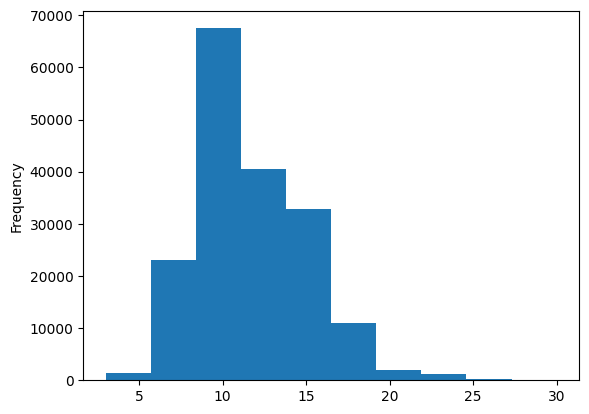

In [14]:
train_df.total_lines.plot.hist()

In [15]:
train_sentences = train_df["text"].tolist()
val_sentences = val_df["text"].tolist()
test_sentences = test_df["text"].tolist()
len(train_sentences), len(val_sentences), len(test_sentences)

(180040, 30212, 30135)

In [16]:
train_sentences[:3]

['to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .']

In [17]:
train_df["target"][:3]

0    OBJECTIVE
1      METHODS
2      METHODS
Name: target, dtype: object

## Make numeric labels (ML models require numeric labels)

In [18]:
from sklearn.preprocessing import OneHotEncoder

one_hot_encoder = OneHotEncoder(sparse_output=False)
train_labels_one_hot = one_hot_encoder.fit_transform(train_df["target"].to_numpy().reshape(-1, 1))
val_labels_one_hot = one_hot_encoder.fit_transform(val_df["target"].to_numpy().reshape(-1, 1))
test_labels_one_hot = one_hot_encoder.fit_transform(test_df["target"].to_numpy().reshape(-1, 1))

train_labels_one_hot

array([[0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])

### Label encode labels

In [19]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_df["target"].to_numpy())
val_labels_encoded = label_encoder.fit_transform(val_df["target"].to_numpy())
test_labels_encoded = label_encoder.fit_transform(test_df["target"].to_numpy())

train_labels_encoded[:10]

array([3, 2, 2, 2, 2, 2, 4, 4, 4, 4])

In [20]:
# Get class names and number of classes from LabelEncoder instance
num_classes = len(label_encoder.classes_)
class_names = label_encoder.classes_
num_classes, class_names

(5,
 array(['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS'],
       dtype=object))

### Model 0: Getting a baseline

In [21]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

model_0 = Pipeline([
    ("tf-idf", TfidfVectorizer()),
    ("clf", MultinomialNB())
])

# Fit the pipeline to the training data
model_0.fit(X=train_sentences,
            y=train_labels_encoded)

# Evaluate baseline on validation dataset
model_0.score(X=val_sentences,
              y=val_labels_encoded)

0.7218323844829869

In [22]:
baseline_preds = model_0.predict(val_sentences)
baseline_preds

array([4, 1, 3, ..., 4, 4, 1])

In [23]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
from helper_functions import calculate_results

--2024-04-18 17:59:37--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2024-04-18 17:59:37 (72.7 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [24]:
baseline_results = calculate_results(y_true=val_labels_encoded,
                                     y_pred=baseline_preds)
baseline_results

{'accuracy': 72.1832384482987,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869,
 'f1': 0.6989250353450294}

### Preparing data for deep learning models

In [25]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers

In [26]:
# How long is each sentence on average?
sent_lens = [len(sentence.split()) for sentence in train_sentences]
avg_sent_len = np.mean(sent_lens)
avg_sent_len

26.338269273494777

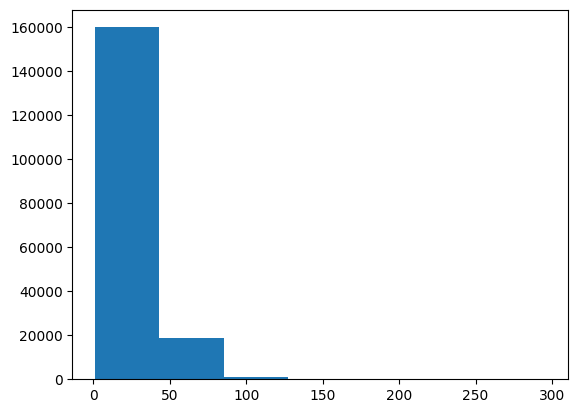

In [27]:
import matplotlib.pyplot as plt
plt.hist(sent_lens, bins=7);

In [28]:
# How long of sentence covers 95% of the length?
output_seq_len = int(np.percentile(sent_lens, 95))
output_seq_len  # 95% sentences in training set have a length 55 tokens

55

In [29]:
# Maximum sentence length in the training set
max(sent_lens)

296

In [30]:
max_tokens = 68000

In [31]:
from tensorflow.keras.layers import TextVectorization

text_vectorizer = TextVectorization(max_tokens=max_tokens,
                                   output_sequence_length=55)

In [32]:
text_vectorizer.adapt(train_sentences)

In [33]:
import random
target_sentence = random.choice(train_sentences)
print(f"Text:\n{target_sentence}")
print(f"\nLength of text: {len(target_sentence.split())}")
print(f"\nVectorized text:\n{text_vectorizer([target_sentence])}")

Text:
the primary patient-reported outcomes were body image and cosmesis at @ weeks .

Length of text: 13

Vectorized text:
[[   2   56 1993   75    9  239 1277    3 8490   15   53    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0]]


In [34]:
# How many words in our training vocabulary?
rct_20k_text_vocab = text_vectorizer.get_vocabulary()
print(f"Number of words in vocabulary: {len(rct_20k_text_vocab)}"),
print(f"Most common words in the vocabulary: {rct_20k_text_vocab[:5]}")
print(f"Least common words in the vocabulary: {rct_20k_text_vocab[-5:]}")

Number of words in vocabulary: 64841
Most common words in the vocabulary: ['', '[UNK]', 'the', 'and', 'of']
Least common words in the vocabulary: ['aainduced', 'aaigroup', 'aachener', 'aachen', 'aaacp']


In [35]:
text_vectorizer.get_config()

{'name': 'text_vectorization',
 'trainable': True,
 'dtype': 'string',
 'batch_input_shape': (None,),
 'max_tokens': 68000,
 'standardize': 'lower_and_strip_punctuation',
 'split': 'whitespace',
 'ngrams': None,
 'output_mode': 'int',
 'output_sequence_length': 55,
 'pad_to_max_tokens': False,
 'sparse': False,
 'ragged': False,
 'vocabulary': None,
 'idf_weights': None,
 'encoding': 'utf-8',
 'vocabulary_size': 64841}

In [36]:
# Create token embedding layer
token_embed = layers.Embedding(input_dim=len(rct_20k_text_vocab),
                               output_dim=128,
                               mask_zero=True,
                               name="token_embedding")

print(f"Sentence before vectorization:\n{target_sentence}\n")
vectorized_sentence = text_vectorizer([target_sentence])
print(f"Sentence after vectorization (before embedding):\n{vectorized_sentence}\n")
embedded_sentence = token_embed(vectorized_sentence)
print(f"Text after embedding:\n{embedded_sentence}\n")
print(f"Embedded sentence shape: {embedded_sentence.shape}")

Sentence before vectorization:
the primary patient-reported outcomes were body image and cosmesis at @ weeks .

Sentence after vectorization (before embedding):
[[   2   56 1993   75    9  239 1277    3 8490   15   53    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0]]

Text after embedding:
[[[-0.04138657 -0.00266875  0.00398605 ...  0.0295458  -0.02598529
   -0.00240854]
  [ 0.02066706 -0.00084888 -0.02381805 ...  0.04859817  0.00711232
    0.01389671]
  [ 0.01116686  0.01123197 -0.03672106 ... -0.04652736  0.00032768
    0.02406603]
  ...
  [ 0.04042114  0.03111408  0.00940704 ...  0.0229273  -0.03656854
    0.00203627]
  [ 0.04042114  0.03111408  0.00940704 ...  0.0229273  -0.03656854
    0.00203627]
  [ 0.04042114  0.03111408  0.00940704 ...  0.0229273  -0.03656854
    0.00203627]]]

Embedded sentence shape:

## Create datasets (as fast as possible)

In [37]:
train_dataset = tf.data.Dataset.from_tensor_slices((train_sentences, train_labels_one_hot))
valid_dataset = tf.data.Dataset.from_tensor_slices((val_sentences, val_labels_one_hot))
test_dataset = tf.data.Dataset.from_tensor_slices((test_sentences, test_labels_one_hot))

train_dataset

<_TensorSliceDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(5,), dtype=tf.float64, name=None))>

In [38]:
# Turn into prefetched batches
train_dataset = train_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
valid_dataset = valid_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

train_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

### Model 1: Conv1D with token embeddings

In [39]:
inputs = layers.Input(shape=(1,), dtype=tf.string)
text_vectors = text_vectorizer(inputs)
token_embedding = token_embed(text_vectors)
x = layers.Conv1D(64, kernel_size=5, padding="same", activation="relu")(token_embedding)
x = layers.GlobalAveragePooling1D()(x)
outputs = layers.Dense(num_classes, activation="softmax")(x)
model_1 = tf.keras.Model(inputs, outputs)

model_1.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

model_1.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVe  (None, 55)                0         
 ctorization)                                                    
                                                                 
 token_embedding (Embedding  (None, 55, 128)           8299648   
 )                                                               
                                                                 
 conv1d (Conv1D)             (None, 55, 64)            41024     
                                                                 
 global_average_pooling1d (  (None, 64)                0         
 GlobalAveragePooling1D)                                         
                                                             

In [40]:
model_1_history = model_1.fit(train_dataset,
                              steps_per_epoch=int(0.1 * len(train_dataset)), # only fit on 10% of batches for faster training time
                              epochs=3,
                              validation_data=valid_dataset,
                              validation_steps=int(0.1 * len(valid_dataset)))

Epoch 1/3
562/562 [==============================] - 68s 119ms/step - loss: 0.9144 - accuracy: 0.6412 - val_loss: 0.6865 - val_accuracy: 0.7387
Epoch 2/3
562/562 [==============================] - 64s 114ms/step - loss: 0.6587 - accuracy: 0.7555 - val_loss: 0.6307 - val_accuracy: 0.7706
Epoch 3/3
562/562 [==============================] - 63s 112ms/step - loss: 0.6175 - accuracy: 0.7750 - val_loss: 0.5946 - val_accuracy: 0.7856


In [41]:
model_1.evaluate(valid_dataset)

945/945 [==============================] - 4s 5ms/step - loss: 0.5967 - accuracy: 0.7868


[0.5966882705688477, 0.7867734432220459]

In [42]:
model_1_pred_probs = model_1.predict(valid_dataset)
model_1_pred_probs

945/945 [==============================] - 6s 6ms/step


array([[4.1990915e-01, 1.8108843e-01, 7.6872259e-02, 2.9695085e-01,
        2.5179356e-02],
       [4.2211303e-01, 2.9383615e-01, 1.3661321e-02, 2.6164162e-01,
        8.7477844e-03],
       [1.4174704e-01, 5.5499971e-03, 1.7910450e-03, 8.5087699e-01,
        3.4853376e-05],
       ...,
       [5.6301219e-06, 7.2684750e-04, 7.5016619e-04, 4.1205540e-06,
        9.9851328e-01],
       [4.9495358e-02, 4.7124672e-01, 8.8219710e-02, 5.9863180e-02,
        3.3117497e-01],
       [1.6699901e-01, 7.2087979e-01, 4.2691249e-02, 3.4092356e-02,
        3.5337534e-02]], dtype=float32)

In [43]:
# Convert pred probs to classes
model_1_preds = tf.argmax(model_1_pred_probs, axis=1)
model_1_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 0, 3, ..., 4, 1, 1])>

In [44]:
model_1_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_1_preds)
model_1_results

{'accuracy': 78.6773467496359,
 'precision': 0.7836878469977363,
 'recall': 0.786773467496359,
 'f1': 0.784223317804711}

In [45]:
random_training_sentence = random.choice(train_sentences)

def split_chars(text):
    return " ".join(list(text))

split_chars(random_training_sentence)

'h o w e v e r   ,   t h i s   p r o c e s s   f r e q u e n t l y   r e s u l t s   i n   p a t i e n t   c o m p l a i n t s   o f   b a c k   p a i n   a n d   d i s c o m f o r t   .'

In [46]:
# Split sequence-level data splits into character-level data splits
train_chars = [split_chars(sentence) for sentence in train_sentences]
val_chars = [split_chars(sentence) for sentence in val_sentences]
test_chars = [split_chars(sentence) for sentence in test_sentences]
print(train_chars[0])

t o   i n v e s t i g a t e   t h e   e f f i c a c y   o f   @   w e e k s   o f   d a i l y   l o w - d o s e   o r a l   p r e d n i s o l o n e   i n   i m p r o v i n g   p a i n   ,   m o b i l i t y   ,   a n d   s y s t e m i c   l o w - g r a d e   i n f l a m m a t i o n   i n   t h e   s h o r t   t e r m   a n d   w h e t h e r   t h e   e f f e c t   w o u l d   b e   s u s t a i n e d   a t   @   w e e k s   i n   o l d e r   a d u l t s   w i t h   m o d e r a t e   t o   s e v e r e   k n e e   o s t e o a r t h r i t i s   (   o a   )   .


In [47]:
char_lens = [len(sentence) for sentence in train_sentences]
mean_char_len = np.mean(char_lens)
mean_char_len

149.3662574983337

(array([1.41175e+05, 3.71110e+04, 1.60000e+03, 1.27000e+02, 2.10000e+01,
        5.00000e+00, 1.00000e+00]),
 array([1.00000000e+00, 1.98857143e+02, 3.96714286e+02, 5.94571429e+02,
        7.92428571e+02, 9.90285714e+02, 1.18814286e+03, 1.38600000e+03]),
 <BarContainer object of 7 artists>)

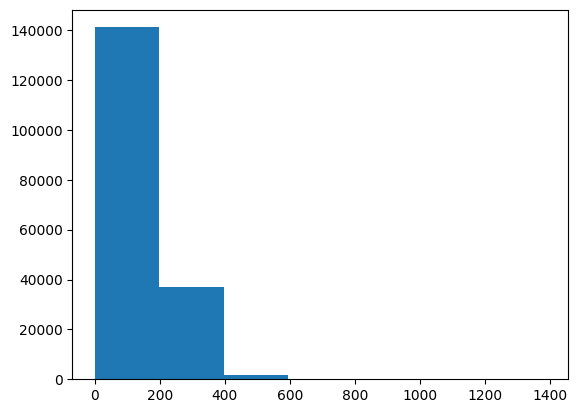

In [48]:
import matplotlib.pyplot as plt
plt.hist(char_lens, bins=7)

In [49]:
# Find what character length covers 95% of sequences
output_seq_char_len = int(np.percentile(char_lens, 95))
output_seq_char_len

290

In [50]:
import string
alphabet = string.ascii_lowercase + string.digits + string.punctuation
alphabet

'abcdefghijklmnopqrstuvwxyz0123456789!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [51]:
# Create char-level token vectorizer instance
NUM_CHAR_TOKENS = len(alphabet) + 2  # num characters in alphabet + space + OOV token
char_vectorizer = TextVectorization(max_tokens=NUM_CHAR_TOKENS,
                                 output_sequence_length=output_seq_char_len,
                                 standardize="lower_and_strip_punctuation",
                                 name="char_vectorizer")

# Adapt character vectorizer to training characters
char_vectorizer.adapt(train_chars)

In [52]:
# Check character vocabulary characteristic
char_vocab = char_vectorizer.get_vocabulary()
print(f"Number of different characters in character vocab: {len(char_vocab)}")
print(f"5 most common characters: {char_vocab[:5]}")
print(f"5 least common characters: {char_vocab[-5:]}")

Number of different characters in character vocab: 28
5 most common characters: ['', '[UNK]', 'e', 't', 'i']
5 least common characters: ['k', 'x', 'z', 'q', 'j']


In [53]:
random_train_chars = random.choice(train_chars)
print(f"Charified text:\n{random_train_chars}")
print(f"\nLength of chars: {len(random_train_chars.split())}")
vectorized_chars = char_vectorizer([random_train_chars])
print(f"\nVectorized chars:\n{vectorized_chars}")
print(f"\nLength of vectorized chars: {len(vectorized_chars[0])}")

Charified text:
t h e   f a s t   t r a c k   p r o t o c o l   i n c l u d e d   n o   p r e o p e r a t i v e   m e c h a n i c a l   b o w e l   i r r i g a t i o n   ,   i m m e d i a t e   o r a l   a l i m e n t a t i o n   a n d   e a r l i e r   p o s t o p e r a t i v e   a m b u l a t i o n   e x e r c i s e   .

Length of chars: 135

Vectorized chars:
[[ 3 13  2 17  5  9  3  3  8  5 11 23 14  8  7  3  7 11  7 12  4  6 11 12
  16 10  2 10  6  7 14  8  2  7 14  2  8  5  3  4 21  2 15  2 11 13  5  6
   4 11  5 12 22  7 20  2 12  4  8  8  4 18  5  3  4  7  6  4 15 15  2 10
   4  5  3  2  7  8  5 12  5 12  4 15  2  6  3  5  3  4  7  6  5  6 10  2
   5  8 12  4  2  8 14  7  9  3  7 14  2  8  5  3  4 21  2  5 15 22 16 12
   5  3  4  7  6  2 24  2  8 11  4  9  2  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0

In [54]:
# Create char embedding layer
char_embed = layers.Embedding(input_dim=NUM_CHAR_TOKENS,
                              output_dim=25,
                              mask_zero=False,
                              name="char_embed")

print(f"Charified text (before vectorizerion and embedding):\n{random_train_chars}\n")
char_embed_example = char_embed(char_vectorizer([random_train_chars]))
print(f"Embedded chars (after vectorization and embedding):\n{char_embed_example}")
print(f"Characted embedding shape: {char_embed_example.shape}")

Charified text (before vectorizerion and embedding):
t h e   f a s t   t r a c k   p r o t o c o l   i n c l u d e d   n o   p r e o p e r a t i v e   m e c h a n i c a l   b o w e l   i r r i g a t i o n   ,   i m m e d i a t e   o r a l   a l i m e n t a t i o n   a n d   e a r l i e r   p o s t o p e r a t i v e   a m b u l a t i o n   e x e r c i s e   .

Embedded chars (after vectorization and embedding):
[[[-0.01128823  0.01233632 -0.00166621 ... -0.00330256  0.00798894
    0.04016289]
  [ 0.00288099 -0.02706121 -0.04450208 ... -0.02640237  0.02902757
    0.02181495]
  [-0.04808388 -0.01333187 -0.03025541 ...  0.02305507 -0.03425282
    0.04085249]
  ...
  [-0.0291726  -0.02278049  0.02784601 ...  0.04433339 -0.03399872
   -0.03472083]
  [-0.0291726  -0.02278049  0.02784601 ...  0.04433339 -0.03399872
   -0.03472083]
  [-0.0291726  -0.02278049  0.02784601 ...  0.04433339 -0.03399872
   -0.03472083]]]
Characted embedding shape: (1, 290, 25)


In [55]:
# Conv1D model
inputs = layers.Input(shape=(1,), dtype="string")
char_vectors = char_vectorizer(inputs)
char_embeddings = char_embed(char_vectors)
x = layers.Conv1D(64, kernel_size=5, padding="same", activation="relu")(char_embeddings)
x = layers.GlobalMaxPool1D()(x)
outputs = layers.Dense(num_classes, activation="softmax")(x)
model_2 = tf.keras.Model(inputs=inputs,
                         outputs=outputs,
                         name="model_2_conv1D_char_embedding")

model_2.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

model_2.summary()

Model: "model_2_conv1D_char_embedding"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 1)]               0         
                                                                 
 char_vectorizer (TextVecto  (None, 290)               0         
 rization)                                                       
                                                                 
 char_embed (Embedding)      (None, 290, 25)           1750      
                                                                 
 conv1d_1 (Conv1D)           (None, 290, 64)           8064      
                                                                 
 global_max_pooling1d (Glob  (None, 64)                0         
 alMaxPooling1D)                                                 
                                                                 
 dense_1 (Dense)             (None, 5

In [56]:
# Char datasets
train_char_dataset = tf.data.Dataset.from_tensor_slices((train_chars, train_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
val_char_dataset = tf.data.Dataset.from_tensor_slices((val_chars, val_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)

train_char_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

In [57]:
model_2_history = model_2.fit(train_char_dataset,
                              steps_per_epoch=int(0.1 * len(train_char_dataset)),
                              epochs=3,
                              validation_data=val_char_dataset,
                              validation_steps=int(0.1 * len(val_char_dataset)))

Epoch 1/3
562/562 [==============================] - 12s 21ms/step - loss: 1.2463 - accuracy: 0.4915 - val_loss: 1.0304 - val_accuracy: 0.5858
Epoch 2/3
562/562 [==============================] - 11s 19ms/step - loss: 0.9932 - accuracy: 0.6013 - val_loss: 0.9319 - val_accuracy: 0.6346
Epoch 3/3
562/562 [==============================] - 10s 18ms/step - loss: 0.9192 - accuracy: 0.6371 - val_loss: 0.8648 - val_accuracy: 0.6755


In [58]:
model_2_pred_probs = model_2.predict(val_char_dataset)
model_2_pred_probs

945/945 [==============================] - 6s 6ms/step


array([[0.24014078, 0.35897148, 0.12174178, 0.22493401, 0.054212  ],
       [0.15105161, 0.39674813, 0.01643343, 0.39201212, 0.04375465],
       [0.10084797, 0.16180018, 0.17193173, 0.53235674, 0.03306331],
       ...,
       [0.03282641, 0.05935387, 0.11850802, 0.06170712, 0.7276046 ],
       [0.04108709, 0.24302506, 0.44838312, 0.06889048, 0.19861424],
       [0.3613054 , 0.23825972, 0.33005095, 0.04423514, 0.02614884]],
      dtype=float32)

In [59]:
model_2_preds = tf.argmax(model_2_pred_probs, axis=1)
model_2_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([1, 1, 3, ..., 4, 2, 0])>

In [60]:
model_2_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_2_preds)
model_2_results

{'accuracy': 65.8281477558586,
 'precision': 0.6590060615945948,
 'recall': 0.658281477558586,
 'f1': 0.6514190224698989}

### Combining pretrained token embeddings + character embeddings (hibrid embedding layer)

In [61]:
# Download pretrained TensorFlow Hub USE
import tensorflow_hub as hub
tf_hub_embedding_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                                        trainable=False,
                                        name="universal_sentence_encoder")

In [62]:
# Test out the embedding on a random sentence
random_training_sentence = random.choice(train_sentences)
print(f"Random training sentence:\n{random_training_sentence}\n")
use_embedded_sentence = tf_hub_embedding_layer([random_training_sentence])
print(f"Sentence after embedding:\n{use_embedded_sentence[0][:30]} (truncated output)...\n")
print(f"Length of sentence embedding:\n{len(use_embedded_sentence[0])}")

Random training sentence:
this study aims to prospectively assess the incidence of hypercalciuria and hypercalcemia with different doses of vitamin d and with a calcium intake of approximately @,@ mg/day .

Sentence after embedding:
[-0.01625399  0.04525743 -0.04509907 -0.06546031 -0.04053823  0.00899155
  0.01334119 -0.01064577  0.05945225  0.01035591  0.07934006 -0.04381738
 -0.0250269  -0.02454879 -0.06382795 -0.03323599 -0.08718628  0.05549637
  0.06397067 -0.05864208  0.00173087 -0.01273315 -0.03810787  0.01241706
  0.0310764  -0.01896818  0.0291939  -0.07023479  0.00529086  0.04686634] (truncated output)...

Length of sentence embedding:
512


In [63]:
# 1. Setup token inputs/model
token_inputs = layers.Input(shape=[], dtype=tf.string, name="token_input")
token_embeddings = tf_hub_embedding_layer(token_inputs)
token_output = layers.Dense(128, activation="relu")(token_embeddings)
token_model = tf.keras.Model(inputs=token_inputs,
                             outputs=token_output)

# 2. Setup char inputs/model
char_inputs = layers.Input(shape=(1,), dtype=tf.string, name="char_input")
char_vectors = char_vectorizer(char_inputs)
char_embeddings = char_embed(char_vectors)
char_bi_lstm = layers.Bidirectional(layers.LSTM(25))(char_embeddings) # bi-LSTM shown in Figure 1 of https://arxiv.org/pdf/1612.05251.pdf
char_model = tf.keras.Model(inputs=char_inputs,
                            outputs=char_bi_lstm)

# 3. Concatenate token and char inputs (create hybrid token embedding)
token_char_concat = layers.Concatenate(name="token_char_hybrid")([token_model.output,
                                                                  char_model.output])

# 4. Create output layers - addition of dropout discussed in 4.2 of https://arxiv.org/pdf/1612.05251.pdf
combined_dropout = layers.Dropout(0.5)(token_char_concat)
combined_dense = layers.Dense(200, activation="relu")(combined_dropout) # slightly different to Figure 1 due to different shapes of token/char embedding layers
final_dropout = layers.Dropout(0.5)(combined_dense)
output_layer = layers.Dense(num_classes, activation="softmax")(final_dropout)

# 5. Construct model with char and token inputs
model_3 = tf.keras.Model(inputs=[token_model.input, char_model.input],
                         outputs=output_layer,
                         name="model_4_token_and_char_embeddings")

In [64]:
model_3.summary()

Model: "model_4_token_and_char_embeddings"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 char_input (InputLayer)     [(None, 1)]                  0         []                            
                                                                                                  
 token_input (InputLayer)    [(None,)]                    0         []                            
                                                                                                  
 char_vectorizer (TextVecto  (None, 290)                  0         ['char_input[0][0]']          
 rization)                                                                                        
                                                                                                  
 universal_sentence_encoder  (None, 512)                  2567978 

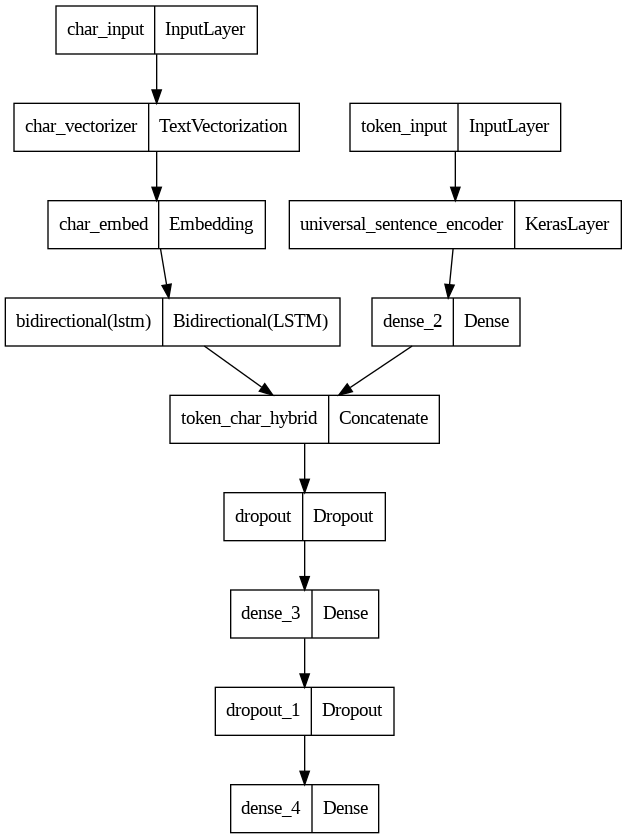

In [65]:
from tensorflow.keras.utils import plot_model
plot_model(model_3)

In [66]:
model_3.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [67]:
# Combine chars and tokens into a dataset
train_char_token_data = tf.data.Dataset.from_tensor_slices((train_sentences, train_chars)) # make dat
train_char_token_labels = tf.data.Dataset.from_tensor_slices(train_labels_one_hot)  # labels
train_char_token_dataset = tf.data.Dataset.zip((train_char_token_data, train_char_token_labels))

# Prefetch and batch train data
train_char_token_dataset = train_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

# Repeat same steps validation data
val_char_token_data = tf.data.Dataset.from_tensor_slices((val_sentences, val_chars))
val_char_token_labels = tf.data.Dataset.from_tensor_slices(val_labels_one_hot)
val_char_token_dataset = tf.data.Dataset.zip((val_char_token_data, val_char_token_labels))

val_char_token_dataset = val_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [68]:
train_char_token_dataset, val_char_token_dataset

(<_PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>,
 <_PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>)

In [69]:
model_3_history = model_3.fit(train_char_token_dataset,
                              steps_per_epoch=int(0.1 * len(train_char_token_dataset)),
                              epochs=3,
                              validation_data=val_char_token_dataset,
                              validation_steps=int(0.1 * len(val_char_token_dataset)))

Epoch 1/3
562/562 [==============================] - 108s 182ms/step - loss: 0.9745 - accuracy: 0.6093 - val_loss: 0.7832 - val_accuracy: 0.7035
Epoch 2/3
562/562 [==============================] - 106s 189ms/step - loss: 0.7990 - accuracy: 0.6940 - val_loss: 0.7189 - val_accuracy: 0.7251
Epoch 3/3
562/562 [==============================] - 129s 230ms/step - loss: 0.7697 - accuracy: 0.7047 - val_loss: 0.6895 - val_accuracy: 0.7384


In [70]:
model_3.evaluate(val_char_token_dataset)

945/945 [==============================] - 68s 72ms/step - loss: 0.6967 - accuracy: 0.7357


[0.696678102016449, 0.7356679439544678]

In [71]:
model_3_pred_probs = model_3.predict(val_char_token_dataset)
model_3_pred_probs

945/945 [==============================] - 48s 49ms/step


array([[4.0106589e-01, 4.1178632e-01, 1.7346948e-03, 1.8013869e-01,
        5.2743517e-03],
       [4.0017107e-01, 3.1442043e-01, 9.9619094e-04, 2.8323352e-01,
        1.1786384e-03],
       [2.7267519e-01, 7.3043309e-02, 1.5909649e-02, 6.2431514e-01,
        1.4056685e-02],
       ...,
       [5.4614025e-04, 7.3578930e-03, 5.9409544e-02, 1.6433962e-04,
        9.3252212e-01],
       [7.5916201e-03, 6.2356006e-02, 2.3399925e-01, 3.0609171e-03,
        6.9299221e-01],
       [1.8642412e-01, 2.9767767e-01, 4.0082243e-01, 3.0909028e-02,
        8.4166721e-02]], dtype=float32)

In [72]:
model_3_preds = tf.argmax(model_3_pred_probs, axis=1)
model_3_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([1, 0, 3, ..., 4, 4, 2])>

In [73]:
model_3_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_3_preds)
model_3_results

{'accuracy': 73.566794651132,
 'precision': 0.7356974619660531,
 'recall': 0.7356679465113201,
 'f1': 0.7337443977870128}

Model 5: Transfer Learning with pretrained token embeddings + character embeddings + positional embeddings

In [74]:
train_df.head()

,target,text,line_number,total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11


In [74]:
train_df["line_number"].value_counts()

<Axes: ylabel='Frequency'>

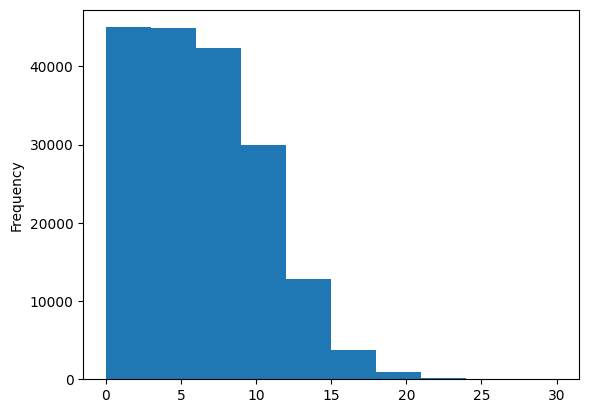

In [75]:
train_df.line_number.plot.hist()

In [76]:
train_line_numbers_one_hot = tf.one_hot(train_df["line_number"].to_numpy(), depth=15)
val_line_numbers_one_hot = tf.one_hot(val_df["line_number"].to_numpy(), depth=15)
test_line_numbers_one_hot = tf.one_hot(test_df["line_number"].to_numpy(), depth=15)

In [77]:
train_line_numbers_one_hot.shape, train_line_numbers_one_hot[:5]

(TensorShape([180040, 15]),
 <tf.Tensor: shape=(5, 15), dtype=float32, numpy=
 array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]],
       dtype=float32)>)

In [78]:
train_df["total_lines"].value_counts()

total_lines
11    24468
10    23639
12    22113
9     19400
13    18438
14    14610
8     12285
15    10768
7      7464
16     7429
17     5202
6      3353
18     3344
19     2480
20     1281
5      1146
21      770
22      759
23      264
4       215
24      200
25      182
26       81
28       58
3        32
30       31
27       28
Name: count, dtype: int64

<Axes: ylabel='Frequency'>

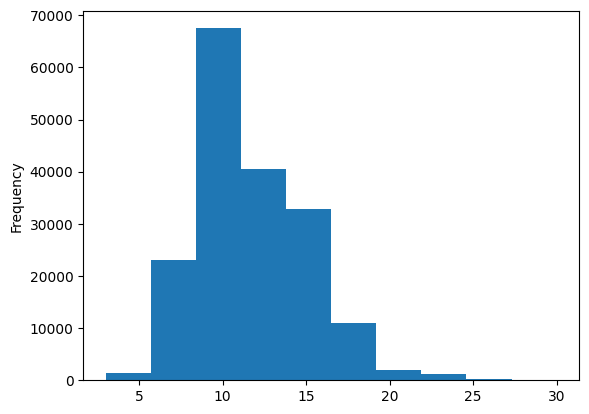

In [79]:
train_df.total_lines.plot.hist()

In [82]:
# Check the coverage of a "total_lines" value of 20
np.percentile(train_df.total_lines, 98)  # a value 20 covers 98% of samples

20.0

In [83]:
train_total_lines_one_hot = tf.one_hot(train_df["total_lines"].to_numpy(), depth=20)
val_total_lines_one_hot = tf.one_hot(val_df["total_lines"].to_numpy(), depth=20)
test_total_lines_one_hot = tf.one_hot(test_df["total_lines"].to_numpy(), depth=20)

train_total_lines_one_hot.shape, train_total_lines_one_hot[:5]

(TensorShape([180040, 20]),
 <tf.Tensor: shape=(5, 20), dtype=float32, numpy=
 array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.]], dtype=float32)>)

In [100]:
# 1. Token inputs
token_inputs = layers.Input(shape=[], dtype="string", name="token_inputs")
token_embeddings = tf_hub_embedding_layer(token_inputs)
token_outputs = layers.Dense(128, activation="relu")(token_embeddings)
token_model = tf.keras.Model(inputs=token_inputs,
                             outputs=token_outputs)
# 2. Char inputs
char_inputs = layers.Input(shape=(1,), dtype="string", name="char_inputs")
char_vectors = char_vectorizer(char_inputs)
char_embeddings = char_embed(char_vectors)
char_bi_lstm = layers.Bidirectional(layers.LSTM(32))(char_embeddings)
char_model = tf.keras.Model(inputs=char_inputs,
                           outputs=char_bi_lstm)

# 3. Line number inputs
line_number_inputs = layers.Input(shape=(15,), dtype=tf.int32, name="line_number_input")
y = layers.Dense(32, activation="relu")(line_number_inputs)
line_number_model = tf.keras.Model(inputs=line_number_inputs,
                                   outputs=y)
# 4 Total lines inputs
total_lines_inputs = layers.Input(shape=(20,), dtype=tf.int32, name="total_lines_input")
y = layers.Dense(32, activation="relu")(total_lines_inputs)
total_line_model = tf.keras.Model(inputs=total_lines_inputs,
                                  outputs=y)
# 5 Combine token and char embeddings input a hibrid embedding
combined_embeddings = layers.Concatenate(name="token_char_hybrid_embedding")([token_model.output,
                                                                              char_model.output])
z = layers.Dense(256, activation="relu")(combined_embeddings)
z = layers.Dropout(rate=0.5)(z)

# 6 Combine positional embeddings with combined token and char embeddings
z = layers.Concatenate(name="token_char_positional_embedding")([line_number_model.output,
                                                                total_line_model.output,
                                                                z])
# 7 Create output layer
output_layer = layers.Dense(5, activation="softmax", name="output_layer")(z)

# 8 Put togeether model
model_4 = tf.keras.Model(inputs=[line_number_model.input,
                                 total_line_model.input,
                                 token_model.input,
                                 char_model.input],
                         outputs=output_layer)

In [101]:
model_4.summary()

Model: "model_22"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 char_inputs (InputLayer)    [(None, 1)]                  0         []                            
                                                                                                  
 token_inputs (InputLayer)   [(None,)]                    0         []                            
                                                                                                  
 char_vectorizer (TextVecto  (None, 290)                  0         ['char_inputs[0][0]']         
 rization)                                                                                        
                                                                                                  
 universal_sentence_encoder  (None, 512)                  2567978   ['token_inputs[0][0]'] 

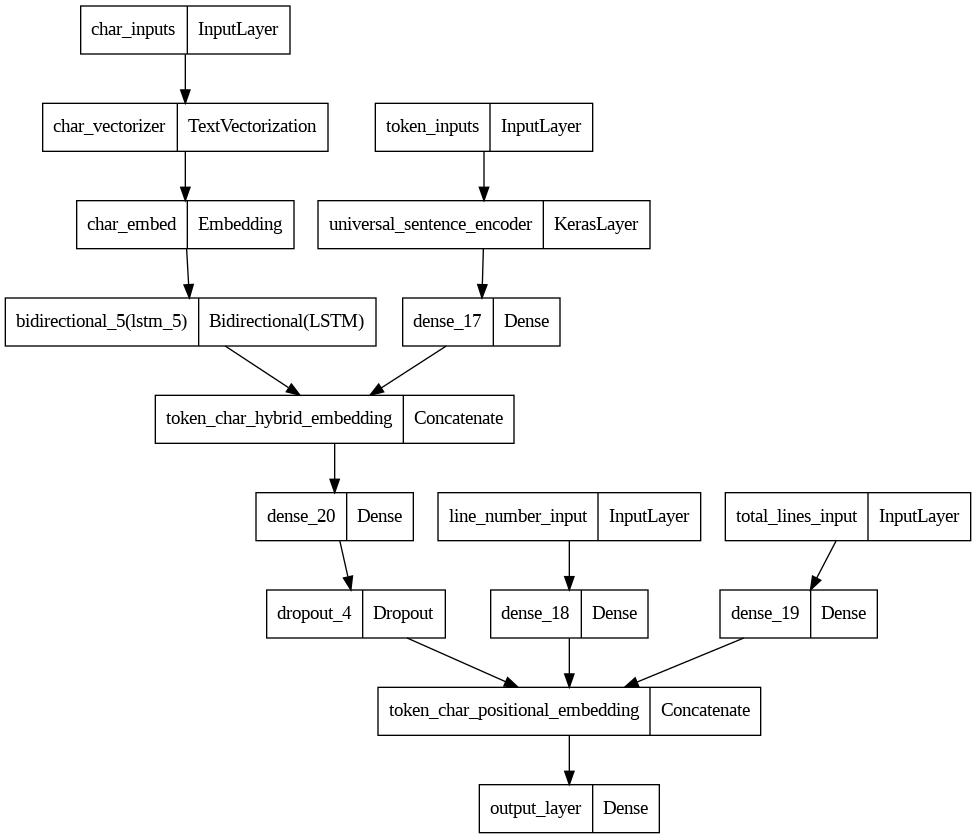

In [102]:
from tensorflow.keras.utils import plot_model
plot_model(model_4)

In [103]:
# Which layers are trainable
for layer in model_4.layers:
  print(layer, layer.trainable)

<keras.src.engine.input_layer.InputLayer object at 0x790a8a801d50> True
<keras.src.engine.input_layer.InputLayer object at 0x790a8a801420> True
<keras.src.layers.preprocessing.text_vectorization.TextVectorization object at 0x790ace8c6ef0> True
<tensorflow_hub.keras_layer.KerasLayer object at 0x790acc6a1360> False
<keras.src.layers.core.embedding.Embedding object at 0x790ae00480d0> True
<keras.src.layers.core.dense.Dense object at 0x790a8a801870> True
<keras.src.layers.rnn.bidirectional.Bidirectional object at 0x790a8b100b20> True
<keras.src.layers.merging.concatenate.Concatenate object at 0x790a8b0638e0> True
<keras.src.engine.input_layer.InputLayer object at 0x790ae0049750> True
<keras.src.engine.input_layer.InputLayer object at 0x790a8b101630> True
<keras.src.layers.core.dense.Dense object at 0x790a8a50d030> True
<keras.src.layers.core.dense.Dense object at 0x790a8b078bb0> True
<keras.src.layers.core.dense.Dense object at 0x790a8a6846a0> True
<keras.src.layers.regularization.dropout.

In [104]:
model_4.compile(loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.2),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [105]:
# Create training and validation datasets (all four kinds of inputs)
train_pos_char_token_data = tf.data.Dataset.from_tensor_slices((train_line_numbers_one_hot, # line numbers
                                                                train_total_lines_one_hot, # total lines
                                                                train_sentences, # train tokens
                                                                train_chars)) # train chars
train_pos_char_token_labels = tf.data.Dataset.from_tensor_slices(train_labels_one_hot) # train labels
train_pos_char_token_dataset = tf.data.Dataset.zip((train_pos_char_token_data, train_pos_char_token_labels)) # combine data and labels
train_pos_char_token_dataset = train_pos_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE) # turn into batches and prefetch appropriately

# Validation dataset
val_pos_char_token_data = tf.data.Dataset.from_tensor_slices((val_line_numbers_one_hot,
                                                              val_total_lines_one_hot,
                                                              val_sentences,
                                                              val_chars))
val_pos_char_token_labels = tf.data.Dataset.from_tensor_slices(val_labels_one_hot)
val_pos_char_token_dataset = tf.data.Dataset.zip((val_pos_char_token_data, val_pos_char_token_labels))
val_pos_char_token_dataset = val_pos_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE) # turn into batches and prefetch appropriately

# Check input shapes
train_pos_char_token_dataset, val_pos_char_token_dataset

(<_PrefetchDataset element_spec=((TensorSpec(shape=(None, 15), dtype=tf.float32, name=None), TensorSpec(shape=(None, 20), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>,
 <_PrefetchDataset element_spec=((TensorSpec(shape=(None, 15), dtype=tf.float32, name=None), TensorSpec(shape=(None, 20), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>)

In [106]:
history_model_4 = model_4.fit(train_pos_char_token_dataset,
                              steps_per_epoch=int(0.1 * len(train_pos_char_token_dataset)),
                              epochs=3,
                              validation_data=val_pos_char_token_dataset,
                              validation_steps=int(0.1 * len(val_pos_char_token_dataset)))


Epoch 1/3
562/562 [==============================] - 156s 267ms/step - loss: 1.0992 - accuracy: 0.7245 - val_loss: 0.9815 - val_accuracy: 0.8045
Epoch 2/3
562/562 [==============================] - 152s 271ms/step - loss: 0.9679 - accuracy: 0.8147 - val_loss: 0.9502 - val_accuracy: 0.8285
Epoch 3/3
562/562 [==============================] - 118s 210ms/step - loss: 0.9517 - accuracy: 0.8231 - val_loss: 0.9393 - val_accuracy: 0.8311


In [107]:
model_4_pred_probs = model_4.predict(val_pos_char_token_dataset, verbose=1)
model_4_pred_probs

945/945 [==============================] - 62s 64ms/step


array([[0.4990519 , 0.10439687, 0.01252307, 0.36567816, 0.01835001],
       [0.54113376, 0.08656142, 0.04137944, 0.3206898 , 0.0102356 ],
       [0.28180397, 0.10363521, 0.14739004, 0.39967453, 0.06749617],
       ...,
       [0.03882591, 0.11384177, 0.03552291, 0.03120552, 0.7806039 ],
       [0.03091745, 0.28480166, 0.07646416, 0.02625846, 0.58155835],
       [0.20233575, 0.5708226 , 0.09057873, 0.05042118, 0.08584173]],
      dtype=float32)

In [108]:
model_4_preds = tf.argmax(model_4_pred_probs, axis=1)
model_4_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 0, 3, ..., 4, 4, 1])>

In [110]:
model_4_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_4_preds)
model_4_results

{'accuracy': 83.29140738779293,
 'precision': 0.8316520689389949,
 'recall': 0.8329140738779293,
 'f1': 0.8317961543316058}

In [112]:
all_model_results = pd.DataFrame({"baseline": baseline_results,
                                 "custom_token_embed_conv1d": model_1_results,
                                 "custom_char_embed_conv1d": model_2_results,
                                 "hibrid_char_token_embed": model_3_results,
                                 "tribrid_pos_char_token_emebed:": model_4_results})

all_model_results = all_model_results.transpose()
all_model_results

,accuracy,precision,recall,f1
baseline,72.183238,0.718647,0.721832,0.698925
custom_token_embed_conv1d,78.677347,0.783688,0.786773,0.784223
custom_char_embed_conv1d,65.828148,0.659006,0.658281,0.651419
hibrid_char_token_embed,73.566795,0.735697,0.735668,0.733744
tribrid_pos_char_token_emebed:,83.291407,0.831652,0.832914,0.831796


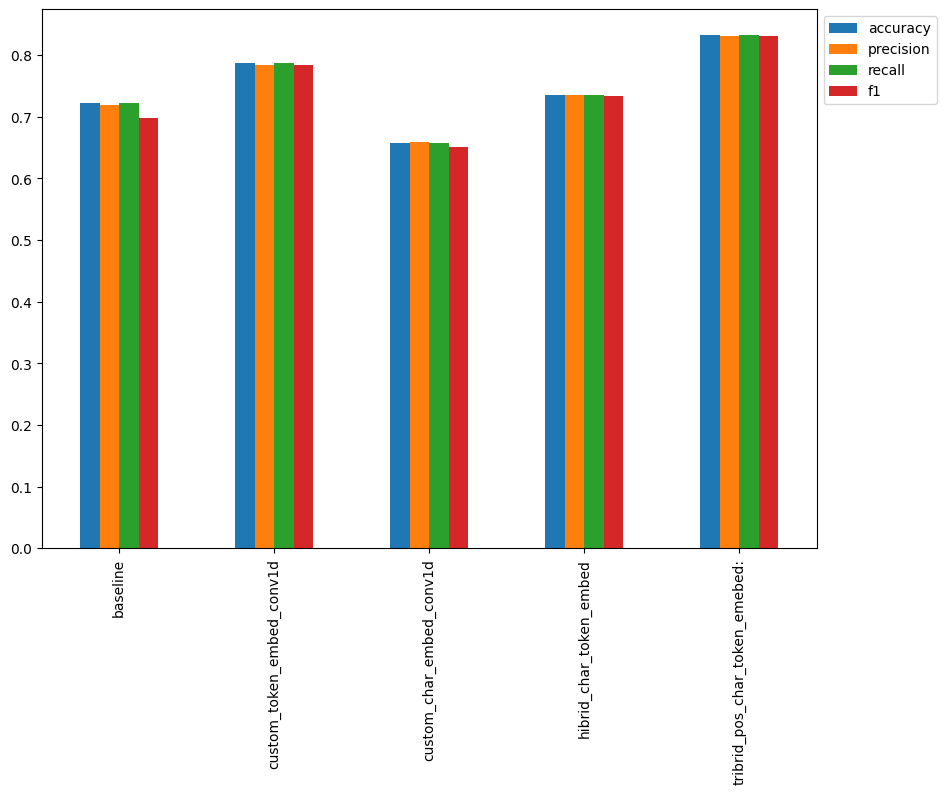

In [114]:
# Reduce the accuracy to the same scale as other matrics
all_model_results["accuracy"] = all_model_results["accuracy"]/100

# Plot and compare all of the model results
all_model_results.plot(kind="bar", figsize=(10, 7)).legend(bbox_to_anchor=(1.0, 1.0));

<Axes: >

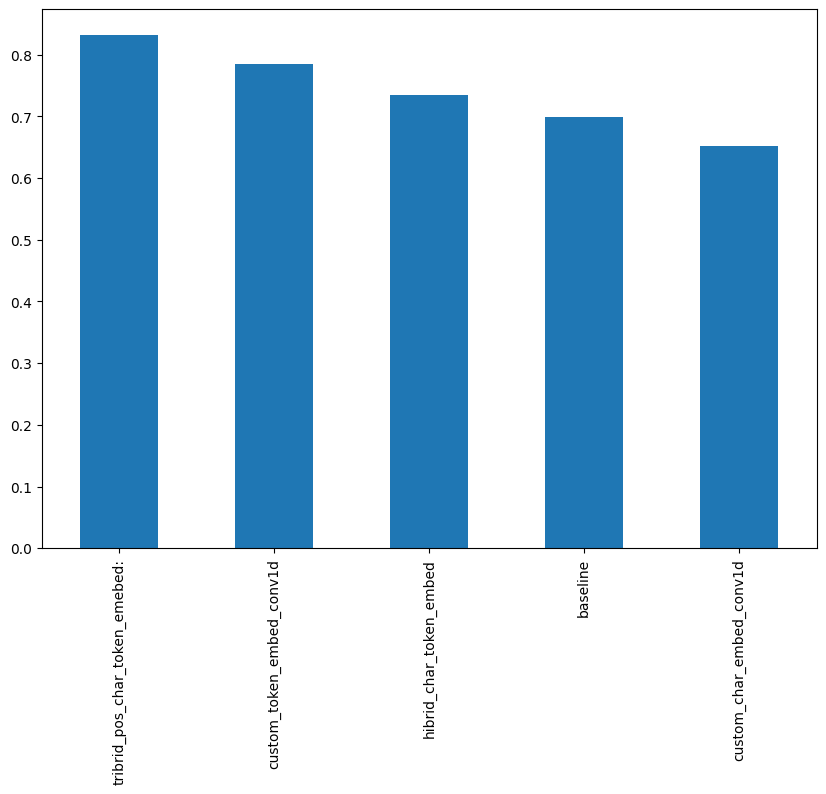

In [119]:
# Sort model results by f1-score
all_model_results.sort_values("f1", ascending=False)["f1"].plot(kind="bar", figsize=(10, 7))

In [120]:
model_4.save("models/skimlit_tribrid_model")

In [121]:
model_path = ("models/skimlit_tribrid_model")
loaded_model = tf.keras.models.load_model(model_path)

In [126]:
loaded_pred_probs = loaded_model.predict(val_pos_char_token_dataset, verbose=1)
loaded_preds = tf.argmax(loaded_pred_probs, axis=1)
loaded_preds[:10]

945/945 [==============================] - 52s 55ms/step


<tf.Tensor: shape=(10,), dtype=int64, numpy=array([0, 0, 3, 2, 2, 4, 4, 4, 4, 1])>

In [127]:
loaded_model_results = calculate_results(val_labels_encoded,
                                         loaded_preds)
loaded_model_results

{'accuracy': 83.29140738779293,
 'precision': 0.8316520689389949,
 'recall': 0.8329140738779293,
 'f1': 0.8317961543316058}

In [129]:
np.isclose(list(model_4_results.values()), list(loaded_model_results.values()), rtol=1e-5)

array([ True,  True,  True,  True])

In [130]:
loaded_model.summary()

Model: "model_22"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 char_inputs (InputLayer)    [(None, 1)]                  0         []                            
                                                                                                  
 token_inputs (InputLayer)   [(None,)]                    0         []                            
                                                                                                  
 char_vectorizer (TextVecto  (None, 290)                  0         ['char_inputs[0][0]']         
 rization)                                                                                        
                                                                                                  
 universal_sentence_encoder  (None, 512)                  2567978   ['token_inputs[0][0]'] 

Evaluate model on test dataset

In [132]:
test_pos_char_token_data = tf.data.Dataset.from_tensor_slices((test_line_numbers_one_hot,
                                                               test_total_lines_one_hot,
                                                               test_sentences,
                                                               test_chars))

test_pos_char_token_labels = tf.data.Dataset.from_tensor_slices(test_labels_one_hot)
test_pos_char_token_dataset = tf.data.Dataset.zip((test_pos_char_token_data, test_pos_char_token_labels))
test_pos_char_token_dataset = test_pos_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

test_pos_char_token_dataset

<_PrefetchDataset element_spec=((TensorSpec(shape=(None, 15), dtype=tf.float32, name=None), TensorSpec(shape=(None, 20), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

In [141]:
test_pred_probs = loaded_model.predict(test_pos_char_token_dataset,
                                       verbose=1)

test_preds = tf.argmax(test_pred_probs, axis=1)
test_preds[:10]

942/942 [==============================] - 53s 56ms/step


<tf.Tensor: shape=(10,), dtype=int64, numpy=array([3, 0, 2, 2, 4, 4, 4, 1, 4, 0])>

In [137]:
loaded_model_test_results = calculate_results(y_true=test_labels_encoded,
                                             y_pred=test_preds)
loaded_model_test_results

{'accuracy': 82.71445163431225,
 'precision': 0.8254934605717393,
 'recall': 0.8271445163431226,
 'f1': 0.8259094105768763}

In [140]:
%%time
# Get list of class names of test predictions
test_pred_classes = [label_encoder.classes_[pred] for pred in test_preds]
test_pred_classes[:10]

CPU times: user 8.64 s, sys: 17.1 ms, total: 8.66 s
Wall time: 8.79 s


['OBJECTIVE',
 'BACKGROUND',
 'METHODS',
 'METHODS',
 'RESULTS',
 'RESULTS',
 'RESULTS',
 'CONCLUSIONS',
 'RESULTS',
 'BACKGROUND']

In [143]:
test_df["prediction"] = test_pred_classes
test_df["pred_prob"] = tf.reduce_max(test_pred_probs, axis=1).numpy()
test_df["correct"] = test_df["prediction"] == test_df["target"]
test_df.head(10)

,target,text,line_number,total_lines,prediction,pred_prob,correct
0,BACKGROUND,this study analyzed liver function abnormaliti...,0,8,OBJECTIVE,0.477126,False
1,RESULTS,a post hoc analysis was conducted with the use...,1,8,BACKGROUND,0.317928,False
2,RESULTS,liver function tests ( lfts ) were measured at...,2,8,METHODS,0.787609,False
3,RESULTS,survival analyses were used to assess the asso...,3,8,METHODS,0.667969,False
4,RESULTS,the percentage of patients with abnormal lfts ...,4,8,RESULTS,0.731941,True
5,RESULTS,when mean hemodynamic profiles were compared i...,5,8,RESULTS,0.878036,True
6,RESULTS,multivariable analyses revealed that patients ...,6,8,RESULTS,0.617285,True
7,CONCLUSIONS,abnormal lfts are common in the adhf populatio...,7,8,CONCLUSIONS,0.549215,True
8,CONCLUSIONS,elevated meld-xi scores are associated with po...,8,8,RESULTS,0.487628,False
9,BACKGROUND,minimally invasive endovascular aneurysm repai...,0,12,BACKGROUND,0.559188,True


In [147]:
top_100_wrong = test_df[test_df["correct"] == False].sort_values("pred_prob", ascending=False)[:10]
top_100_wrong[:5]


,target,text,line_number,total_lines,prediction,pred_prob,correct
13874,CONCLUSIONS,symptom outcomes will be assessed and estimate...,4,6,METHODS,0.952720,False
16347,BACKGROUND,to evaluate the effects of the lactic acid bac...,0,12,OBJECTIVE,0.939031,False
2388,RESULTS,the primary endpoint is the cumulative three-y...,4,13,METHODS,0.933868,False
8545,METHODS,pretest-posttest .,1,11,BACKGROUND,0.931212,False
23630,RESULTS,the primary outcome was to evaluate changes in...,6,14,METHODS,0.931174,False


In [149]:
import json

# Download and open example abstracts
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/skimlit_example_abstracts.json

with open("skimlit_example_abstracts.json", "r") as f:
  example_abstracts = json.load(f)

example_abstracts[0]

--2024-04-18 20:31:53--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/skimlit_example_abstracts.json
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.108.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6737 (6.6K) [text/plain]
Saving to: ‘skimlit_example_abstracts.json.1’

skimlit_example_abs 100%[===================>]   6.58K  --.-KB/s    in 0s      

2024-04-18 20:31:53 (65.4 MB/s) - ‘skimlit_example_abstracts.json.1’ saved [6737/6737]



{'abstract': 'This RCT examined the efficacy of a manualized social intervention for children with HFASDs. Participants were randomly assigned to treatment or wait-list conditions. Treatment included instruction and therapeutic activities targeting social skills, face-emotion recognition, interest expansion, and interpretation of non-literal language. A response-cost program was applied to reduce problem behaviors and foster skills acquisition. Significant treatment effects were found for five of seven primary outcome measures (parent ratings and direct child measures). Secondary measures based on staff ratings (treatment group only) corroborated gains reported by parents. High levels of parent, child and staff satisfaction were reported, along with high levels of treatment fidelity. Standardized effect size estimates were primarily in the medium and large ranges and favored the treatment group.',
 'source': 'https://pubmed.ncbi.nlm.nih.gov/20232240/',
 'details': 'RCT of a manualized 

In [151]:
abstracts = pd.DataFrame(example_abstracts)
abstracts

,abstract,source,details
0,This RCT examined the efficacy of a manualized...,https://pubmed.ncbi.nlm.nih.gov/20232240/,RCT of a manualized social treatment for high-...
1,Postpartum depression (PPD) is the most preval...,https://pubmed.ncbi.nlm.nih.gov/28012571/,Formatting removed (can be used to compare mod...
2,"Mental illness, including depression, anxiety ...",https://pubmed.ncbi.nlm.nih.gov/28942748/,Effect of nutrition on mental health
3,Hepatitis C virus (HCV) and alcoholic liver di...,https://pubmed.ncbi.nlm.nih.gov/22244707/,Baclofen promotes alcohol abstinence in alcoho...


In [153]:
# Create sentencier
from spacy.lang.en import English

nlp = English()  # Setup English sentence parser
sentencizer = nlp.add_pipe("sentencizer")

# Create "doc" of parsed sequences, change index for a different abstract
doc = nlp(example_abstracts[0]["abstract"])
abstract_lines = [str(sent) for sent in list(doc.sents)] # return detected sentences from doc in string type (not spaCy token type)
abstract_lines


['This RCT examined the efficacy of a manualized social intervention for children with HFASDs.',
 'Participants were randomly assigned to treatment or wait-list conditions.',
 'Treatment included instruction and therapeutic activities targeting social skills, face-emotion recognition, interest expansion, and interpretation of non-literal language.',
 'A response-cost program was applied to reduce problem behaviors and foster skills acquisition.',
 'Significant treatment effects were found for five of seven primary outcome measures (parent ratings and direct child measures).',
 'Secondary measures based on staff ratings (treatment group only) corroborated gains reported by parents.',
 'High levels of parent, child and staff satisfaction were reported, along with high levels of treatment fidelity.',
 'Standardized effect size estimates were primarily in the medium and large ranges and favored the treatment group.']

In [154]:
total_lines_in_sample = len(abstract_lines)

# Go through each line in abstract and create a list of dictionaries containing features for each line
sample_lines = []
for i, line in enumerate(abstract_lines):
  sample_dict = {}
  sample_dict["text"] = str(line)
  sample_dict["line_number"] = i
  sample_dict["total_lines"] = total_lines_in_sample - 1
  sample_lines.append(sample_dict)

sample_lines

[{'text': 'This RCT examined the efficacy of a manualized social intervention for children with HFASDs.',
  'line_number': 0,
  'total_lines': 7},
 {'text': 'Participants were randomly assigned to treatment or wait-list conditions.',
  'line_number': 1,
  'total_lines': 7},
 {'text': 'Treatment included instruction and therapeutic activities targeting social skills, face-emotion recognition, interest expansion, and interpretation of non-literal language.',
  'line_number': 2,
  'total_lines': 7},
 {'text': 'A response-cost program was applied to reduce problem behaviors and foster skills acquisition.',
  'line_number': 3,
  'total_lines': 7},
 {'text': 'Significant treatment effects were found for five of seven primary outcome measures (parent ratings and direct child measures).',
  'line_number': 4,
  'total_lines': 7},
 {'text': 'Secondary measures based on staff ratings (treatment group only) corroborated gains reported by parents.',
  'line_number': 5,
  'total_lines': 7},
 {'text'

In [160]:
# Get all line_number values from sample abstract
test_abstract_line_numbers = [line["line_number"] for line in sample_lines]
test_abstract_line_numbers_one_hot = tf.one_hot(test_abstract_line_numbers, depth=15)
test_abstract_line_numbers_one_hot

<tf.Tensor: shape=(8, 15), dtype=float32, numpy=
array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.]],
      dtype=float32)>

In [164]:
test_abstract_total_lines = [line["total_lines"] for line in sample_lines]
test_abstract_total_lines_one_hot = tf.one_hot(test_abstract_total_lines, depth=20)
test_abstract_total_lines_one_hot

<tf.Tensor: shape=(8, 20), dtype=float32, numpy=
array([[0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.]], dtype=float32)>

In [168]:
abstract_chars = [split_chars(sentence) for sentence in abstract_lines]
abstract_chars[0]

'T h i s   R C T   e x a m i n e d   t h e   e f f i c a c y   o f   a   m a n u a l i z e d   s o c i a l   i n t e r v e n t i o n   f o r   c h i l d r e n   w i t h   H F A S D s .'

In [169]:
%%time
test_abstract_pred_probs = loaded_model.predict(x=(test_abstract_line_numbers_one_hot,
                                                   test_abstract_total_lines_one_hot,
                                                   tf.constant(abstract_lines),
                                                   tf.constant(abstract_chars)))
test_abstract_pred_probs

1/1 [==============================] - 3s 3s/step
CPU times: user 2.38 s, sys: 5.84 ms, total: 2.39 s
Wall time: 3.59 s


array([[0.318776  , 0.1426766 , 0.01869992, 0.49348125, 0.02636621],
       [0.06861366, 0.02648517, 0.7398283 , 0.0903125 , 0.07476036],
       [0.14512692, 0.04500405, 0.5033075 , 0.1887841 , 0.11777742],
       [0.09212413, 0.12203471, 0.5504897 , 0.06866709, 0.16668439],
       [0.06506701, 0.11626123, 0.37749055, 0.05106841, 0.39011288],
       [0.03646846, 0.12037104, 0.60563433, 0.03884351, 0.1986826 ],
       [0.02600419, 0.13990536, 0.06901904, 0.02393255, 0.7411389 ],
       [0.01629323, 0.11950049, 0.21450393, 0.02814471, 0.62155765]],
      dtype=float32)

In [170]:
test_abstract_preds = tf.argmax(test_abstract_pred_probs, axis=1)
test_abstract_preds

<tf.Tensor: shape=(8,), dtype=int64, numpy=array([3, 2, 2, 2, 4, 2, 4, 4])>

In [171]:
test_abstract_pred_classes = [label_encoder.classes_[0] for i in test_abstract_preds]
test_abstract_pred_classes

['BACKGROUND',
 'BACKGROUND',
 'BACKGROUND',
 'BACKGROUND',
 'BACKGROUND',
 'BACKGROUND',
 'BACKGROUND',
 'BACKGROUND']

In [173]:
# Visualize abstract lines and predicted sequence labels
for i, line in enumerate(abstract_lines):
  print(f"{test_abstract_pred_classes[i]}: {line}")

BACKGROUND: This RCT examined the efficacy of a manualized social intervention for children with HFASDs.
BACKGROUND: Participants were randomly assigned to treatment or wait-list conditions.
BACKGROUND: Treatment included instruction and therapeutic activities targeting social skills, face-emotion recognition, interest expansion, and interpretation of non-literal language.
BACKGROUND: A response-cost program was applied to reduce problem behaviors and foster skills acquisition.
BACKGROUND: Significant treatment effects were found for five of seven primary outcome measures (parent ratings and direct child measures).
BACKGROUND: Secondary measures based on staff ratings (treatment group only) corroborated gains reported by parents.
BACKGROUND: High levels of parent, child and staff satisfaction were reported, along with high levels of treatment fidelity.
BACKGROUND: Standardized effect size estimates were primarily in the medium and large ranges and favored the treatment group.
